## All user analysis

In [5]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt

In [6]:
parent_dir = './merged_and_cleaned_data'

entries = os.listdir(parent_dir)

print("User directories found:")
for entry in entries:
    print(entry)
print(len(entries))

User directories found:
a48
a4k
acy
aiz
arl
b69
bg7
bjb
bln
blw
bn0
bp6
bxn
ceg
csv
cuf
cv9
d3i
d70
dbf
dca
del
dlv
e6n
e89
e8d
ea5
eg5
eix
ep3
etz
ezs
f1z
f49
f56
f98
fce
fv6
gtw
gw6
gz2
h0y
h58
ha1
heh
hht
hti
hx1
i48
i4j
iss
itd
ixj
izr
j6r
jm2
jpo
jqv
js7
jy4
jzq
kev
kgv
koj
kt9
kxo
l6d
l8d
l93
lce
lh5
lr2
mda
mjk
mst
mvm
n1a
n3n
nbh
nbm
ng4
nko
nme
nu0
o15
o4n
odl
of0
ok9
oma
op9
p8k
plu
plx
q1i
q6d
qhl
qmq
qoh
qt5
qup
qyv
r2p
ruy
rve
s1i
sih
siz
sk5
spe
su5
t52
t6s
t7n
tay
tf5
tgh
tmw
ttl
tve
um6
una
uvn
uxg
v31
v6e
vaf
vb5
vdw
vgy
vqk
vsm
w08
w47
w7j
w80
wgn
wo0
wu1
wy3
x50
x5u
x68
x7x
xbk
xfe
xhq
xle
xm7
xmh
xtn
xur
xzj
y18
y2b
y98
yab
yeb
yfi
z27
z8b
za7
zcx
zhj
zrq
zrw
zvy
zwp
168


### Meta dictionary

In [7]:
# Function to process calories.csv
def process_calories_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Ensure dateTime is a datetime type
    df['dateTime'] = pd.to_datetime(df['dateTime'])

    # Data start and end dates
    data_start_date = df['dateTime'].iloc[0]
    data_end_date = df['dateTime'].iloc[-1]
    
    # Generate a complete range of dates between start and end
    all_dates = pd.date_range(start=data_start_date, end=data_end_date).date
    
    # Find absent data days
    present_dates = df['dateTime'].dt.date.unique()
    absent_dates = sorted(set(all_dates) - set(present_dates))
    
    # Most common value in the `value` column for the first day
    first_day = data_start_date.date()
    basal_metabolic_rate = df[df['dateTime'].dt.date == first_day]['value'].mode()[0]
    
    # Identifying void data days
    void_data_days = []
    for date in present_dates:
        day_data = df[df['dateTime'].dt.date == date]
        if day_data['value'].nunique() == 1 and day_data['value'].iloc[0] == basal_metabolic_rate:
            void_data_days.append(date)
    
    # Exclude absent and void data days from the DataFrame
    valid_dates = [date for date in present_dates if date not in absent_dates and date not in void_data_days]
    df = df[df['dateTime'].dt.date.isin(valid_dates)]

    # Aggregate data by hour and calculate the sum for each hour
    df.set_index('dateTime', inplace=True)
    hourly_aggregates = df.resample('h').sum().reset_index()

    # Restructuring the aggregation
    aggregated_data = {}
    for _, row in hourly_aggregates.iterrows():
        date_key = row['dateTime'].strftime('%Y-%m-%d')
        if date_key not in aggregated_data:
            aggregated_data[date_key] = []
        aggregated_data[date_key].append({
            'hour': row['dateTime'].hour,
            'value': round(row['value'], 1)
        })
    
    # Prepare the result
    result = {
        'data_start_date': data_start_date.strftime('%Y-%m-%d'),
        'data_end_date': data_end_date.strftime('%Y-%m-%d'),
        'absent_data_days_count': len(absent_dates),
        'absent_data_days': [date.strftime('%Y-%m-%d') for date in absent_dates],
        'basal_metabolic_rate': basal_metabolic_rate,
        'void_data_days_count': len(void_data_days),
        'void_data_days': [date.strftime('%Y-%m-%d') for date in void_data_days],
        'aggregated_data': aggregated_data  # Adding aggregated data to the result
    }
    
    return result


In [8]:
def process_minutes_sedentary_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Ensure dateTime is a datetime type and sort it
    df['dateTime'] = pd.to_datetime(df['dateTime'])

    # Determine the start and end dates
    data_start_date = df['dateTime'].min().date()
    data_end_date = df['dateTime'].max().date()

    # Generate a complete range of dates between start and end
    all_dates = pd.date_range(start=data_start_date, end=data_end_date).date
    
    # Find absent data days
    present_dates = df['dateTime'].dt.date.unique()
    absent_dates = sorted(set(all_dates) - set(present_dates))

    # Identifying void data days
    void_data_days = []
    for date in present_dates:
        day_data = df[df['dateTime'].dt.date == date]
        if (day_data['value'] == 1).all():  # Assuming 'value' column holds the data
            void_data_days.append(date)

    # Exclude absent and void data days from the DataFrame
    valid_dates = [date for date in present_dates if date not in absent_dates and date not in void_data_days]
    df = df[df['dateTime'].dt.date.isin(valid_dates)]

    # Aggregate data by hour and calculate the sum for each hour
    df.set_index('dateTime', inplace=True)
    hourly_aggregates = df.resample('h').sum().reset_index()

    # Restructuring the aggregation
    aggregated_data = {}
    for _, row in hourly_aggregates.iterrows():
        date_key = row['dateTime'].strftime('%Y-%m-%d')
        if date_key not in aggregated_data:
            aggregated_data[date_key] = []
        aggregated_data[date_key].append({
            'hour': row['dateTime'].hour,
            'value': round(row['value'], 1)
        })
    
    # Prepare the result
    result = {
        'sensor_file': file_path.split('/')[-1],
        'data_start_date': data_start_date.strftime('%Y-%m-%d'),
        'data_end_date': data_end_date.strftime('%Y-%m-%d'),
        'absent_data_days_count': len(absent_dates),
        'absent_data_days': [date.strftime('%Y-%m-%d') for date in absent_dates],
        'void_data_days_count': len(void_data_days),
        'void_data_days': [date.strftime('%Y-%m-%d') for date in void_data_days],
        'aggregated_data': aggregated_data  # Adding aggregated data to the result
    }
    
    return result

In [9]:
def process_sensor_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Ensure dateTime is a datetime type and sort it
    df['dateTime'] = pd.to_datetime(df['dateTime'])

    # Determine the start and end dates
    data_start_date = df['dateTime'].min().date()
    data_end_date = df['dateTime'].max().date()

    # Generate a complete range of dates between start and end
    all_dates = pd.date_range(start=data_start_date, end=data_end_date).date
    
    # Find absent data days
    present_dates = df['dateTime'].dt.date.unique()
    absent_dates = sorted(set(all_dates) - set(present_dates))

    # Identifying void data days
    void_data_days = []
    for date in present_dates:
        day_data = df[df['dateTime'].dt.date == date]
        if (day_data['value'] == 0).all():  # Assuming 'value' column holds the data
            void_data_days.append(date)
    
    # Exclude absent and void data days from the DataFrame
    valid_dates = [date for date in present_dates if date not in absent_dates and date not in void_data_days]
    df = df[df['dateTime'].dt.date.isin(valid_dates)]

    # Aggregate data by hour and calculate the sum for each hour
    df.set_index('dateTime', inplace=True)
    hourly_aggregates = df.resample('h').sum().reset_index()

    # Restructuring the aggregation
    aggregated_data = {}
    for _, row in hourly_aggregates.iterrows():
        date_key = row['dateTime'].strftime('%Y-%m-%d')
        if date_key not in aggregated_data:
            aggregated_data[date_key] = []
        aggregated_data[date_key].append({
            'hour': row['dateTime'].hour,
            'value': round(row['value'], 1)
        })
    
    # Prepare the result
    result = {
        'sensor_file': file_path.split('/')[-1],
        'data_start_date': data_start_date.strftime('%Y-%m-%d'),
        'data_end_date': data_end_date.strftime('%Y-%m-%d'),
        'absent_data_days_count': len(absent_dates),
        'absent_data_days': [date.strftime('%Y-%m-%d') for date in absent_dates],
        'void_data_days_count': len(void_data_days),
        'void_data_days': [date.strftime('%Y-%m-%d') for date in void_data_days],
        'aggregated_data': aggregated_data  # Adding aggregated data to the result
    }
    
    return result

In [13]:
import pandas as pd

def process_sleep_sensor_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Ensure dateTime is a datetime type
    df['dateTime'] = pd.to_datetime(df['dateTime'])
    
    # Extract date and hour from dateTime for aggregation
    df['date'] = df['dateTime'].dt.date
    df['hour'] = df['dateTime'].dt.hour
    
    # Determine the start and end dates
    data_start_date = df['date'].min()
    data_end_date = df['date'].max()
    
    # Generate a complete range of dates between start and end
    all_dates = pd.date_range(start=data_start_date, end=data_end_date).date
    
    # Find absent data days
    present_dates = df['date'].unique()
    absent_dates = sorted(set(all_dates) - set(present_dates))
    
    # Prepare for hourly aggregation of sleep levels
    # Aggregating data by day and hour, and then by level
    # Ensure only the 'seconds' column is summed by specifying the aggregation explicitly
    grouped = df.groupby(['date', 'hour', 'level'])['seconds'].sum().reset_index()

    
    # Restructuring the aggregation for JSON
    aggregated_data = {}
    for _, row in grouped.iterrows():
        date_key = row['date'].strftime('%Y-%m-%d')
        hour_key = str(row['hour'])
        if date_key not in aggregated_data:
            aggregated_data[date_key] = {}
        if hour_key not in aggregated_data[date_key]:
            aggregated_data[date_key][hour_key] = []
        aggregated_data[date_key][hour_key].append({
            'level': row['level'],
            'value': int(row['seconds'])  # Assuming seconds should be an integer
        })
    
    # Prepare the result
    result = {
        'sensor_file': file_path.split('/')[-1],
        'data_start_date': data_start_date.strftime('%Y-%m-%d'),
        'data_end_date': data_end_date.strftime('%Y-%m-%d'),
        'absent_data_days_count': len(absent_dates),
        'absent_data_days': [date.strftime('%Y-%m-%d') for date in absent_dates],
        'void_data_days_count': 0,
        'void_data_days': [],
        'aggregated_data': aggregated_data
    }
    
    return result


In [11]:
import csv
import json

# Load CSV data
def load_csv_data(filename):
    data = {}
    with open(filename, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            pid = row['PID']
            if pid not in data or row['Source'] == 'Fitbit Return':
                data[pid] = {
                    'start_date': row['Start Date'],
                    'end_date': row['End Date']
                }
    return data

# Load the JSON data
def load_json_data(filename):
    with open(filename, 'r') as file:
        return json.load(file)

# Update the JSON data
def update_json_data(json_data, csv_data):
    for pid, dates in csv_data.items():
        if pid in json_data:
            json_data[pid]['official_start_date'] = dates['start_date']
            json_data[pid]['official_end_date'] = dates['end_date']

# Save the updated JSON data
def save_json_data(filename, data):
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)

In [14]:
# Define or import your functions here
# process_calories_csv(file_path)
# process_sensor_csv(file_path, sensor_name)
# process_minutes_sedentary_csv(file_path)

# Assuming the directory structure is /parent_dir/user_id/FitBit/
parent_dir = './merged_and_cleaned_data'

# List of sensors to process with the generic process_sensor_csv function
sensor_list = ['distance', 'elevation', 'floors', 'heart_rate', 'minutesFairlyActive', 'minutesLightlyActive', 'minutesVeryActive', 'steps']

# Initialize a dictionary to hold all user data
all_users_data = {}

iteration_count = 0

for user_dir in os.listdir(parent_dir):
    user_path = os.path.join(parent_dir, user_dir)
    if os.path.isdir(user_path):
        fitbit_path = os.path.join(user_path, 'FitBit')
        if os.path.exists(fitbit_path) and os.path.isdir(fitbit_path):
            user_data = {}
            # Process sleep.csv specifically
            sleep_file_path = os.path.join(fitbit_path, 'sleep.csv')
            if os.path.exists(sleep_file_path):
                user_data['sleep'] = process_sleep_sensor_csv(sleep_file_path)

            # Process calories.csv specifically
            calories_file_path = os.path.join(fitbit_path, 'calories.csv')
            if os.path.exists(calories_file_path):
                user_data['calories'] = process_calories_csv(calories_file_path)
            
            # Process minutesSedentary.csv specifically
            minutes_sedentary_file_path = os.path.join(fitbit_path, 'minutesSedentary.csv')
            if os.path.exists(minutes_sedentary_file_path):
                user_data['minutesSedentary'] = process_minutes_sedentary_csv(minutes_sedentary_file_path)
            
            # Process other sensors
            for sensor in sensor_list:
                sensor_file_path = os.path.join(fitbit_path, f'{sensor}.csv')
                if os.path.exists(sensor_file_path):
                    user_data[sensor] = process_sensor_csv(sensor_file_path)
            
            # Add user data to the all users data dictionary
            all_users_data[user_dir] = user_data
            iteration_count += 1  # Increment the iteration count after processing each user
            if iteration_count == 1:
                partial_json_path = f'./fitbit_data_partial_{iteration_count}.json'
                with open(partial_json_path, 'w') as file:
                    json.dump(all_users_data, file, indent=4)
                print(f"Data saved after processing {iteration_count} users.")
            # Every ten iterations, write the current state to a JSON file
            if iteration_count % 10 == 0:
                partial_json_path = f'./fitbit_data_partial_{iteration_count}.json'
                with open(partial_json_path, 'w') as file:
                    json.dump(all_users_data, file, indent=4)
                print(f"Data saved after processing {iteration_count} users.")

# Convert the all users data dictionary to a JSON string
json_data = json.dumps(all_users_data, indent=4)

# Write the JSON data to a file
json_file_path = './fitbit_data.json'
with open(json_file_path, 'w') as file:
    file.write(json_data)

# Inform the user of completion
print(f"Processed data for all users has been saved to {json_file_path}")

csv_filename = 'pids.csv'
json_filename = 'fitbit_data_partial_80.json'

# Load, process, and update the data
csv_data = load_csv_data(csv_filename)
json_data = load_json_data(json_filename)
update_json_data(json_data, csv_data)
save_json_data(json_filename, json_data)

print("JSON file has been updated.")

Data saved after processing 1 users.


KeyboardInterrupt: 

In [ ]:
meta_dict = {}
sensor_list = ['calories', 'distance', 'elevation', 'floors', 'heart_rate', 'minutesFairlyActive', 
               'minutesLightlyActive', 'minutesSedentary', 'minutesVeryActive', 'sleep', 'steps']



In [ ]:
meta_dict = {}
sensor_list = ['calories', 'distance', 'elevation', 'floors', 'heart_rate', 'minutesFairlyActive', 
               'minutesLightlyActive', 'minutesSedentary', 'minutesVeryActive', 'sleep', 'steps']

for i, user in enumerate(entries):
    sensor_dir = os.path.join(parent_dir, 'Data', user, 'Fitbit')
    sensor_dict = {}
    for sensor in sensor_list:
        sensor_file_name = sensor +'.csv'
        file_path = os.path.join(sensor_dir, sensor_file_name)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, encoding='mac-roman')
            df['dateTime'].dropna(inplace=True)
            if not df.empty:
                df['dateTime'] = pd.to_datetime(df['dateTime'], unit='ns')
                df = df.sort_values('dateTime')
                unique_days = df['dateTime'].dt.date.unique()
                unique_days_count = len(unique_days)
                start_date = df['dateTime'].iloc[0].date()
                end_date = df['dateTime'].iloc[-1].date()
                delta = (end_date - start_date).days
                # missing_days_count = delta - unique_days_count + 1
                all_days_dict = {}
                missing_days_list = []
                for i in range(delta+1):
                    all_days_dict[start_date + timedelta(days=i)] = i
                for k in all_days_dict.keys():
                    if k not in unique_days:
                        missing_days_list.append(str(k))
                missing_days_count = len(missing_days_list)
                appliance = unique_days_count / delta if delta !=0 else 0 
                sensor_dict[sensor] = {'start_date': str(start_date), 'end_date': str(end_date), 
                                       'missing_days_count': missing_days_count, 'missing_dates': missing_days_list, 'appliance': appliance}
            
    if os.path.exists(sensor_dir):  
        meta_dict[user] = sensor_dict

In [ ]:
# print(start_date)
# print(end_date)

2021-09-15
2022-05-01


### save json

In [ ]:
with open(root_path+'/meta_dictionary_fibit.json', 'w') as f:
    json.dump(meta_dict, f)

In [ ]:
f = open(root_path+'/meta_dictionary_fibit.json')
meta_dict = json.load(f)
len(list(meta_dict))

175

In [ ]:
c = 0
j = 0
k = 0
missing_days_matrix = np.zeros((8,4))
for user, sensors in meta_dict.items():
    missing_day_sensor_matrix = np.zeros((20,8))
    i = 0
    for sensor, entries in sensors.items():
        missing_day_sensor_matrix[j, i] = entries['missing_days_count']
        i += 1
            
    if (c + 1) % 50 == 0 or c == len(meta_dict.keys()) - 1:
        missing_days_aggregated = np.sum(missing_day_sensor_matrix, axis = 0)
        missing_days_matrix[:, k] = missing_days_aggregated
        k += 1
        j = 0

    c += 1

In [ ]:
missing_days_matrix

array([[ 13.,  41.,   5.,  18.],
       [ 10.,  39.,   3.,  18.],
       [ 10.,   3.,   2.,   2.],
       [ 12.,  25., 135.,  34.],
       [  9.,   3.,   2.,   2.],
       [ 10.,   3.,   2.,   2.],
       [  8.,   3.,   2.,   2.],
       [  9.,   3.,   2.,   2.]])

In [ ]:
missing_days_aggregated

array([18., 18.,  2., 34.,  2.,  2.,  2.,  2.])

In [ ]:
def visualize_data(values_from_sensors):
    # Adjusting the example data for 8 categories

    # Number of categories
    N = values_from_sensors.shape[1]

    # Adjusting segments for 8 categories
    segments = {
        'battery_charges': values_from_sensors[0],
        'battery_discharges': values_from_sensors[1],
        'battery': values_from_sensors[2],
        'calls': values_from_sensors[3],
        'locations': values_from_sensors[4],
        'screen': values_from_sensors[5],
        'sensor_wifi': values_from_sensors[6],
        'plugin_ios_activity_recognition': values_from_sensors[7]
    }

    colors = ['red', 'green', 'blue', 'orange'] # , 'purple', 'brown', 'pink', 'gray'

    # The x locations for the groups
    ind = np.arange(N)
    # The width of the bars
    width = 0.35

    # Plotting each segment for 8 categories
    bottoms = np.zeros(N)
    bars = []

    for i, (segment, color) in enumerate(zip(segments.values(), colors)):
        bars.append(plt.bar(ind, segment, width, bottom=bottoms, color=color))
        bottoms += np.array(segment)

    plt.ylabel('No. of Missing Days')
    plt.xlabel('No. of Users')
    plt.title('Missing Days for Each Sensor')
    plt.xticks(ind, ('0-49', '50-99', '100-149', '150-176'), rotation=45)  # '0-19', '20-39', '40-59', '60-79', '80-99', '100-119', '120-139', '140-159'
    plt.yticks(np.arange(0, np.sum(values_from_sensors[:, 2]), 20))
    plt.legend([bar[0] for bar in bars], segments.keys())
    plt.tight_layout()
    plt.show()


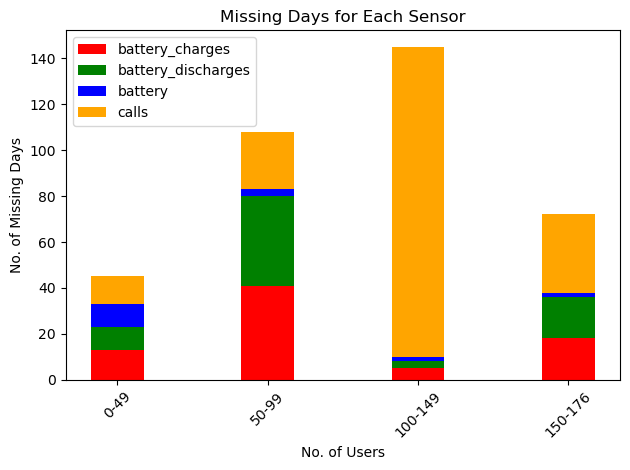

In [ ]:
visualize_data(missing_days_matrix)    

### Compliance

In [ ]:
len(list(meta_dict.keys()))

174

In [ ]:
r1 = 0.30
r2 = 0.50
r3 = 0.70
r4 = 0.90

r1_count = 0
r2_count = 0
r3_count = 0
r4_count = 0
r5_count = 0

sensor_wise_appliance = {'calories': [], 'distance': [], 'elevation': [], 'floors': [], 'heart_rate': [], 'minutesFairlyActive': [], 
               'minutesLightlyActive': [], 'minutesSedentary': [], 'minutesVeryActive': [], 'sleep': [], 'steps': []}

for user, sensors in meta_dict.items():
    
    
    for sensor, entries in sensors.items():
        appliance = entries['appliance']
        if appliance > r4:
            r5_count += 1
        elif appliance > r3 and appliance < r4:
            r4_count += 1
        elif appliance > r2 and appliance < r3:
            r3_count += 1
        elif appliance > r1 and appliance < r2:
            r2_count += 1
        else:
            r1_count += 1
        
        appliance_list_per_sensor = [r1_count, r2_count, r3_count, r4_count, r5_count]
        sensor_appliance_from_dict = sensor_wise_appliance[sensor]
        
        if not sensor_appliance_from_dict:
            sensor_wise_appliance[sensor] = appliance_list_per_sensor
        else:
            sensor_wise_appliance[sensor] = [sensor_appliance_from_dict[i] + appliance_list_per_sensor[i] for i in range(len(appliance_list_per_sensor))]
        r1_count = 0
        r2_count = 0
        r3_count = 0
        r4_count = 0
        r5_count = 0

In [ ]:
sensor_wise_appliance

{'calories': [0, 5, 134, 0, 36],
 'distance': [0, 5, 134, 0, 36],
 'elevation': [0, 5, 134, 0, 36],
 'floors': [0, 5, 134, 0, 36],
 'heart_rate': [3, 3, 5, 21, 143],
 'minutesFairlyActive': [0, 5, 134, 0, 36],
 'minutesLightlyActive': [0, 5, 134, 0, 36],
 'minutesSedentary': [0, 5, 134, 0, 36],
 'minutesVeryActive': [0, 5, 134, 0, 36],
 'sleep': [6, 3, 29, 36, 99],
 'steps': [0, 5, 134, 0, 36]}

In [ ]:
# data = sensor_wise_appliance

# # Define the x-axis according to the given list
# x_axis = ['< 30 (%)', '30 - 49 (%)', '50 - 69 (%)', '70 - 89 (%)', ' > 90 (%)']

# # Create bar plots for each category using the specified x-axis and the dictionary values as y-axis
# fig, axs = plt.subplots(len(data), 1, figsize=(10, 20))

# for i, (category, values) in enumerate(data.items()):
#     axs[i].bar(x_axis, values, width=0.05, color=plt.cm.Paired(i / len(data)))
#     axs[i].set_title(category)
#     # Setting the y-axis to automatically scale based on the values might be more informative
#     axs[i].set_ylabel('Number of Users')
#     axs[i].set_xlabel('Compliance')
#     axs[i].set_xticks(x_axis)

# plt.tight_layout()
# plt.show()

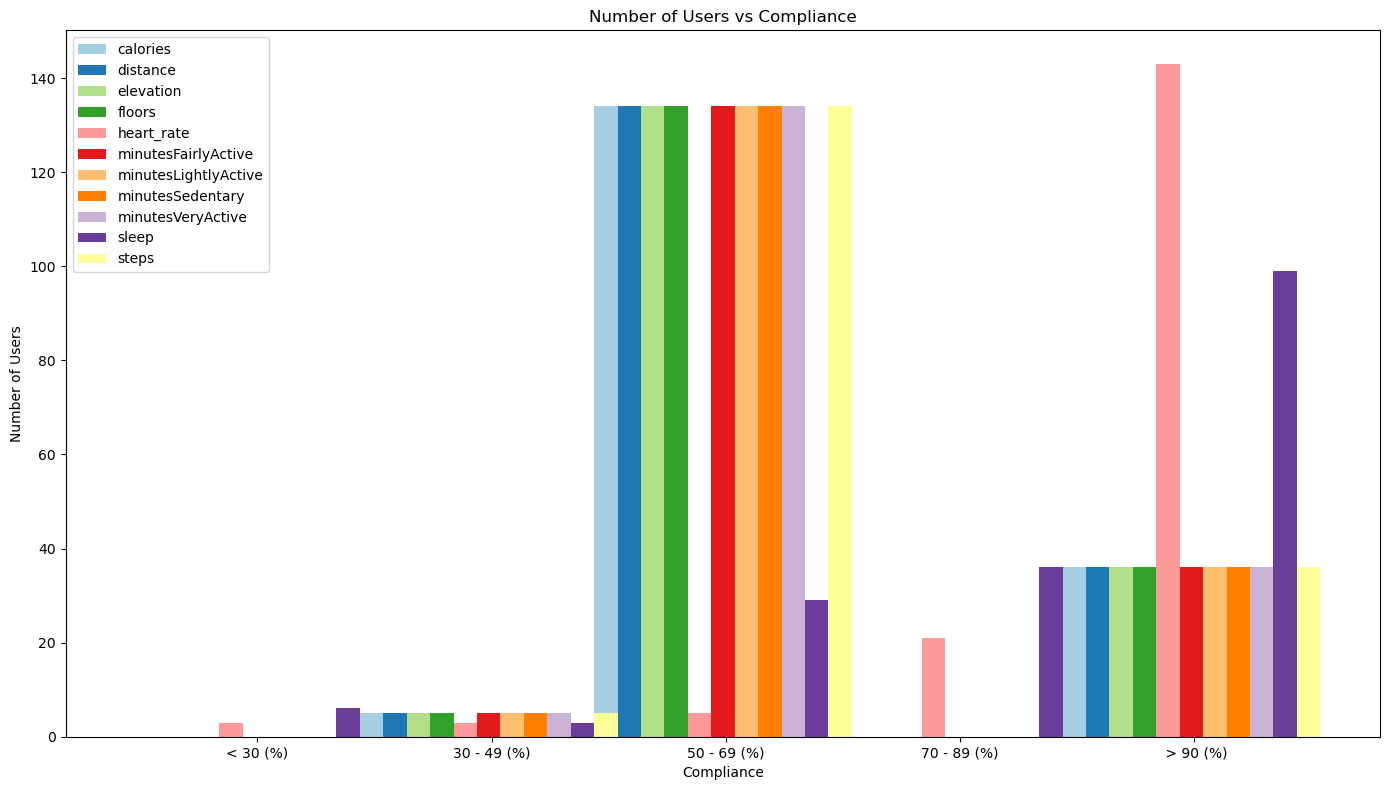

In [ ]:
data = sensor_wise_appliance

# Define the x-axis according to the given list
x_axis = ['< 30 (%)', '30 - 49 (%)', '50 - 69 (%)', '70 - 89 (%)', ' > 90 (%)']

# Setup the figure and axes
fig, ax = plt.subplots(figsize=(14, 8))

# Bar width and spacing configuration
bar_width = 0.1
spacing = 0.15  # Additional space between groups to avoid overlap

# Calculate positions for each category's bars
for i, (category, values) in enumerate(data.items()):
    positions = [x + (i * bar_width) + (spacing / 2) for x in np.arange(len(x_axis))]
    ax.bar(positions, values, width=bar_width, label=category, color=plt.cm.Paired(i / len(data)))

# Set labels and title
ax.set_xlabel('Compliance')
ax.set_ylabel('Number of Users')
ax.set_title('Number of Users vs Compliance')

# Adjust x-ticks to center them in each group
ax.set_xticks([x + len(data) * (bar_width / 2) + (spacing / 4) for x in range(len(x_axis))])
ax.set_xticklabels(x_axis)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()

### Missing Days

In [ ]:
r1 = 10
r2 = 30
r3 = 50
r4 = 100

r1_count = 0
r2_count = 0
r3_count = 0
r4_count = 0
r5_count = 0

sensor_wise_appliance =  {'calories': [], 'distance': [], 'elevation': [], 'floors': [], 'heart_rate': [], 'minutesFairlyActive': [], 
               'minutesLightlyActive': [], 'minutesSedentary': [], 'minutesVeryActive': [], 'sleep': [], 'steps': []}

for user, sensors in meta_dict.items():
    
    for sensor, entries in sensors.items():
        appliance = entries['missing_days_count']
        flag = False
        if appliance > r4:
            r5_count += 1
        elif appliance > r3 and appliance < r4:
            r4_count += 1
        elif appliance > r2 and appliance < r3:
            r3_count += 1
        elif appliance > r1 and appliance < r2:
            r2_count += 1
        else:
            r1_count += 1
        
        appliance_list_per_sensor = [r1_count, r2_count, r3_count, r4_count, r5_count]
        sensor_appliance_from_dict = sensor_wise_appliance[sensor]
            
        if not sensor_appliance_from_dict:
            sensor_wise_appliance[sensor] = appliance_list_per_sensor
        else:
            sensor_wise_appliance[sensor] = [sensor_appliance_from_dict[i] + appliance_list_per_sensor[i] for i in range(len(appliance_list_per_sensor))]
        r1_count = 0
        r2_count = 0
        r3_count = 0
        r4_count = 0
        r5_count = 0

In [ ]:
sensor_wise_appliance

{'calories': [36, 0, 0, 0, 139],
 'distance': [36, 0, 0, 0, 139],
 'elevation': [36, 0, 0, 0, 139],
 'floors': [36, 0, 0, 0, 139],
 'heart_rate': [128, 27, 10, 5, 5],
 'minutesFairlyActive': [36, 0, 0, 0, 139],
 'minutesLightlyActive': [36, 0, 0, 0, 139],
 'minutesSedentary': [36, 0, 0, 0, 139],
 'minutesVeryActive': [36, 0, 0, 0, 139],
 'sleep': [85, 30, 12, 27, 19],
 'steps': [36, 0, 0, 0, 139]}

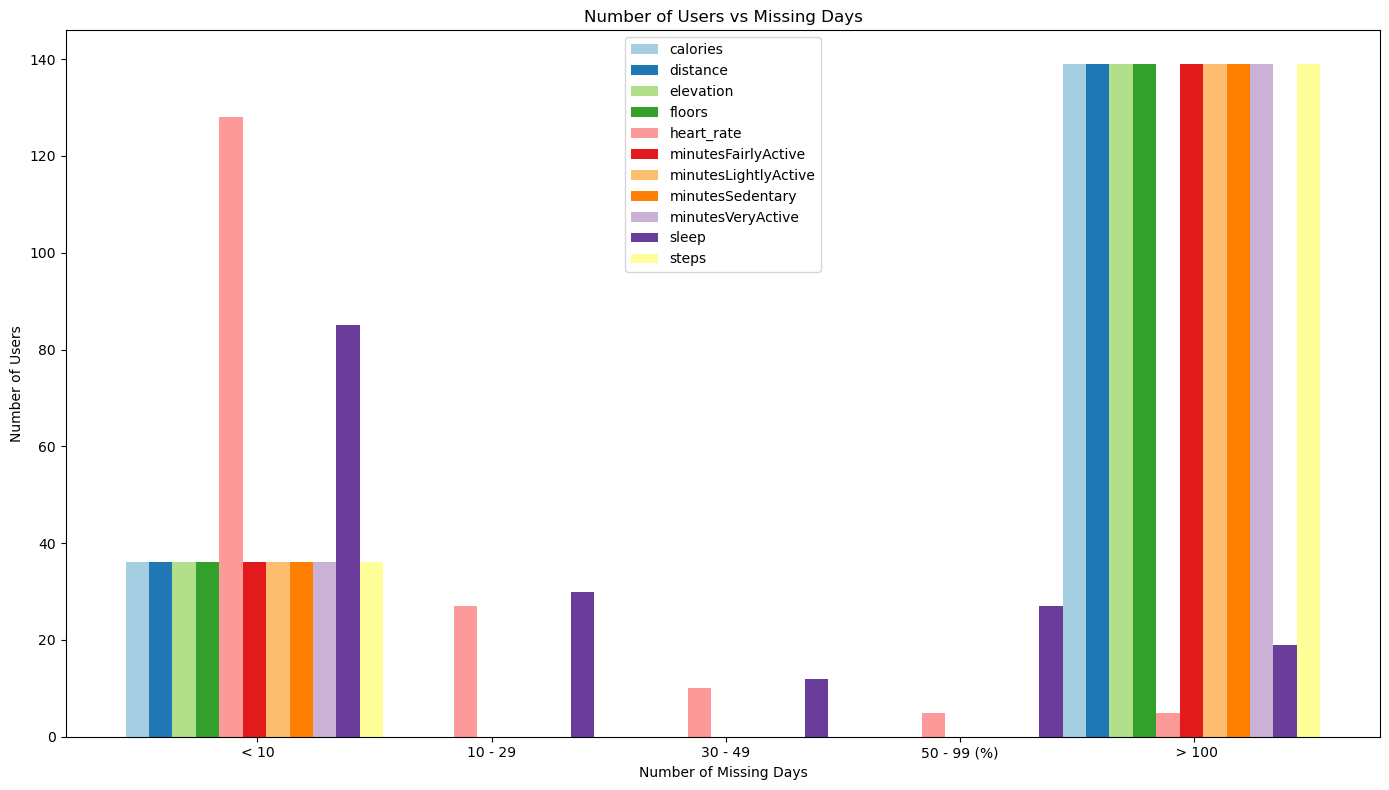

In [ ]:
data = sensor_wise_appliance

# Define the x-axis according to the given list
x_axis = ['< 10', '10 - 29', '30 - 49', '50 - 99 (%)', ' > 100']

# Setup the figure and axes
fig, ax = plt.subplots(figsize=(14, 8))

# Bar width and spacing configuration
bar_width = 0.1
spacing = 0.15  # Additional space between groups to avoid overlap

# Calculate positions for each category's bars
for i, (category, values) in enumerate(data.items()):
    positions = [x + (i * bar_width) + (spacing / 2) for x in np.arange(len(x_axis))]
    ax.bar(positions, values, width=bar_width, label=category, color=plt.cm.Paired(i / len(data)))

# Set labels and title
ax.set_xlabel('Number of Missing Days')
ax.set_ylabel('Number of Users')
ax.set_title('Number of Users vs Missing Days')

# Adjust x-ticks to center them in each group
ax.set_xticks([x + len(data) * (bar_width / 2) + (spacing / 4) for x in range(len(x_axis))])
ax.set_xticklabels(x_axis)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()

### Gantt chart from each user

In [ ]:
# data = {
#     'u1': {'s1': {'a': 11, 'b': 0.9},
#            's2': {'a': 8, 'b': 0.5},
#            's3': {'a': 5, 'b': 0.7}},
#     'u2': {'s1': {'a': 11, 'b': 0.9},
#            's2': {'a': 8, 'b': 0.5},
#            's3': {'a': 5, 'b': 0.7}}
# }

data = meta_dict

# Initialize variables to keep track of the max and min values for key 'b' and their corresponding top-level keys
max_value_b = float('-inf')
min_value_b = float('inf')
key_with_max_value_b = None
key_with_min_value_b = None

# Iterate through the dictionary to check only key 'b'
for key, subdict in data.items():
    for subkey, values in subdict.items():
        value_b = values.get('appliance')  # Get the value associated with key 'b'
        if value_b is not None:
            # Update max and min values for 'b' and their corresponding keys
            if value_b > max_value_b:
                max_value_b = value_b
                key_with_max_value_b = key
            if value_b < min_value_b:
                min_value_b = value_b
                key_with_min_value_b = key

print(f"Key with max 'compliance' value: {key_with_max_value_b}, Max 'compliance' Value: {max_value_b}")
print(f"Key with min 'compliance' value: {key_with_min_value_b}, Min 'compliance' Value: {min_value_b}")

Key with max 'compliance' value: qmq, Max 'compliance' Value: 1.1111111111111112
Key with min 'compliance' value: ybp, Min 'compliance' Value: 0


In [ ]:
keys = ['qmq', 'sih', 'ybp']
data = {x:meta_dict[x] for x in keys}

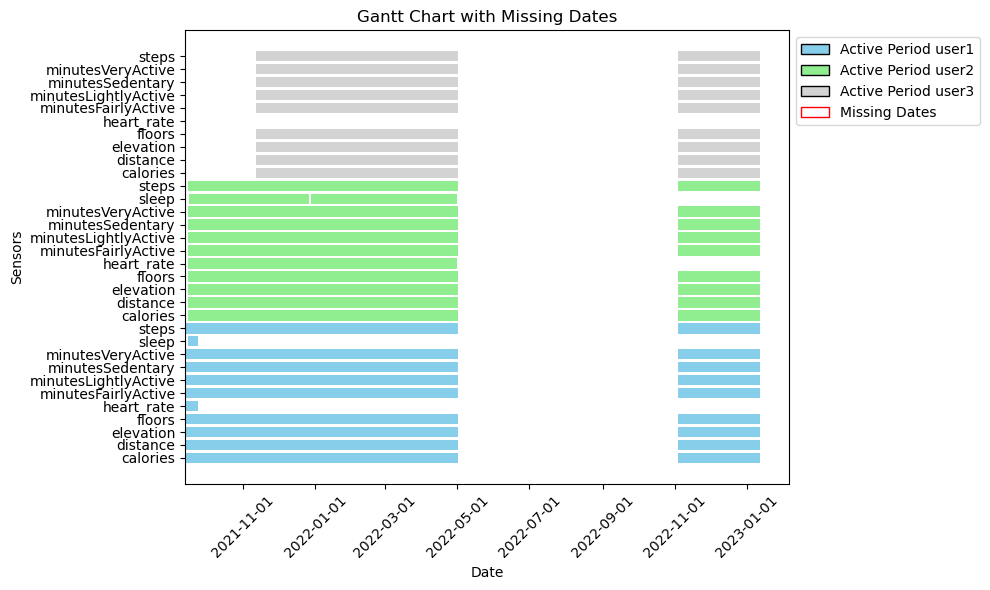

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = 0
colors = {'qmq': 'skyblue', 'sih': 'lightgreen', 'ybp': 'lightgray'}

for user, tasks in data.items():
    for task, details in tasks.items():
        start_date = datetime.strptime(details['start_date'], '%Y-%m-%d')
        end_date = datetime.strptime(details['end_date'], '%Y-%m-%d')
        b_dates = [datetime.strptime(date, '%Y-%m-%d') for date in details['missing_dates']]

        # Plot the overall active period
        ax.barh(y_pos, (end_date - start_date).days, left=mdates.date2num(start_date), color=colors[user])
        
        # Overlay the excluded dates
        for ex_date in b_dates:
            ax.barh(y_pos, 1, left=mdates.date2num(ex_date), color='white', edgecolor='none')

        y_pos += 1

# Setting labels and formatting dates on the x-axis
ax.set_yticks(range(y_pos))
ax.set_yticklabels([f"{task}" for user in data for task in data[user]])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
ax.set_xlabel('Date')
ax.set_ylabel('Sensors')
ax.set_title('Gantt Chart with Missing Dates')

# Manually define the legend
legend_handles = [Patch(facecolor=colors['qmq'], edgecolor='black', label='Active Period user1'),
                  Patch(facecolor=colors['sih'], edgecolor='black', label='Active Period user2'),
                  Patch(facecolor=colors['ybp'], edgecolor='black', label='Active Period user3'),
                  Patch(facecolor='white', edgecolor='red', label='Missing Dates')]
plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()
